***Introducion***

This project will explore historical data on game sales, user and expert ratings, genres and platforms from 1980 to 2016. It is necessary to identify the factors influencing the success of the game in order to plan advertising campaigns for 2017.
First, you need to prepare the data for analysis, find errors, omissions and duplicates in them. Next, it is necessary to analyze changes in sales across platforms, identify the current period on the basis of which forecasts will be made. To see if user reviews and critics have an impact on sales, analyze the distribution of games by genre, which are the most popular.
Next, create a portrait of users of the NA, EU, JP regions, analyze sales by platform, by genre, and depending on the ESRB rating. And in the end, check the hypotheses: the average user ratings of the Xbox One and PC platforms are the same and the average user ratings of the genres Action (English "action", action games) and Sports (English "sports competitions") are different.

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
from scipy import stats as st
import matplotlib.pyplot as plt

In [3]:
games = pd.read_csv('games.csv')
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


## Data preparation

In [4]:
games = games.rename(columns={'Name':'name', 'Platform':'platform', 'Year_of_Release':'year_of_release',\
'Genre':'genre', 'NA_sales':'na_sales', 'EU_sales':'eu_sales', 'JP_sales':'jp_sales', 'Other_sales':'other_sales',\
'Critic_Score':'critic_score', 'User_Score':'user_score', 'Rating':'rating'})
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


We delete the lines with omissions in the column with the year of release, because this data is quite small (only 269 out of 16713, which is less than 2%)

In [5]:
games = games.dropna(subset=['year_of_release'])
games['year_of_release'] = games['year_of_release'].astype('int')

In [6]:
games.isna().sum()

name                  2
platform              0
year_of_release       0
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8463
user_score         6607
rating             6678
dtype: int64

In [7]:
games = games.dropna(subset=['name'])

The analysis did not reveal any obvious duplicates

In [8]:
games.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
16710    False
16711    False
16712    False
16713    False
16714    False
Length: 16444, dtype: bool

In [9]:
games['user_score'] = games['user_score'].replace('tbd', np.nan)
games['user_score'].isna().sum()

8981

In [10]:
games['user_score'] = pd.to_numeric(games['user_score'], errors='coerce', downcast='float')
games['user_score'] = games['user_score'].astype('float64')

In [11]:
print(games['critic_score'].unique())

[76. nan 82. 80. 89. 58. 87. 91. 61. 97. 95. 77. 88. 83. 94. 93. 85. 86.
 98. 96. 90. 84. 73. 74. 78. 92. 71. 72. 68. 62. 49. 67. 81. 66. 56. 79.
 70. 59. 64. 75. 60. 63. 69. 50. 25. 42. 44. 55. 48. 57. 29. 47. 65. 54.
 20. 53. 37. 38. 33. 52. 30. 32. 43. 45. 51. 40. 46. 39. 34. 41. 36. 31.
 27. 35. 26. 19. 28. 23. 24. 21. 17. 13.]


First, fill in the gaps in the critic_score column with zeros so that it is possible to change the data type of the column, but we do not know the real ratings of critics, and we cannot delete the gaps, because there are quite a lot of them and they can affect further research, and so we can simply apply filtering

In [14]:
games['critic_score'] = games['critic_score'].fillna(-1)
games['critic_score'] = games['critic_score'].astype('int')

games['rating'] = games['rating'].fillna(-1)

In [15]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     16444 non-null  int64  
 9   user_score       7463 non-null   float64
 10  rating           16444 non-null  object 
dtypes: float64(5), int64(2), object(4)
memory usage: 1.5+ MB


We replace the tbd values in the column with user ratings with nan, because tbd means that the rating is being updated, that is, it is not yet available

As it seemed from studying the data, omissions in the columns with ratings from critics and users, as well as the rating column, are primarily found in games released at the end of the 20th century and at the beginning of the 21st (in the first decade), that is, data on these games could simply be not updated or lost

In [16]:
games['region_sales'] = games[['na_sales', 'jp_sales', 'eu_sales', 'other_sales']].sum(axis=1)

In [17]:
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,region_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1,NaN,-1,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1,NaN,-1,31.38


## Research data analysis

In general, if we take into account the number of games that were released after 2002, we can assume that the years in which fewer than at least 100 games were released, that is, before 1994, can be ignored, since this seems too small a number

<AxesSubplot:xlabel='year_of_release'>

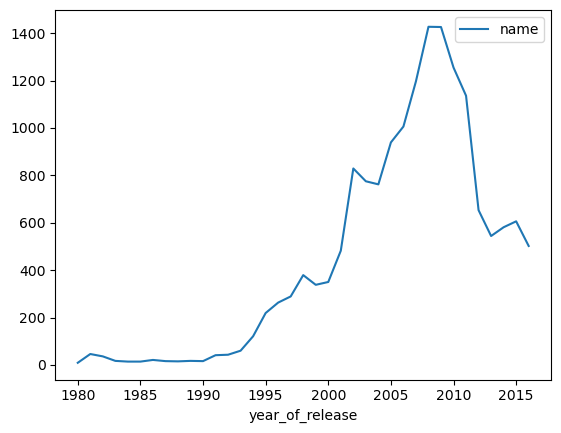

In [18]:
games.pivot_table(index='year_of_release', values='name', aggfunc='count').plot()

In [19]:
games = games.loc[games['year_of_release'] >= 1994]

In [20]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16079 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16079 non-null  object 
 1   platform         16079 non-null  object 
 2   year_of_release  16079 non-null  int64  
 3   genre            16079 non-null  object 
 4   na_sales         16079 non-null  float64
 5   eu_sales         16079 non-null  float64
 6   jp_sales         16079 non-null  float64
 7   other_sales      16079 non-null  float64
 8   critic_score     16079 non-null  int64  
 9   user_score       7460 non-null   float64
 10  rating           16079 non-null  object 
 11  region_sales     16079 non-null  float64
dtypes: float64(6), int64(2), object(4)
memory usage: 1.6+ MB


We look at which platforms had the highest sales in total by region. Based on the summary table, the top 6 platforms were selected

<AxesSubplot:xlabel='platform'>

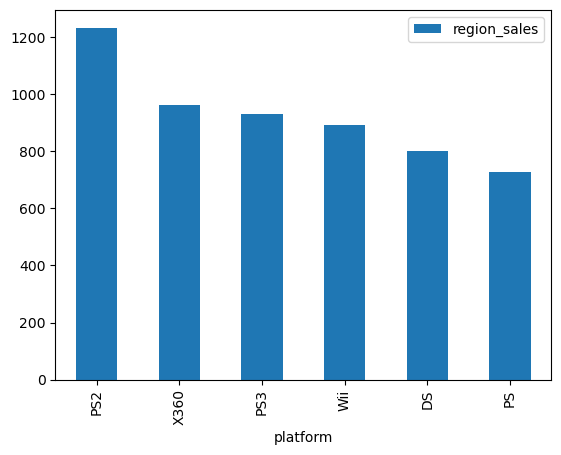

In [21]:
platform_sales = games.pivot_table(index='platform', values='region_sales', aggfunc='sum')
platform_sales = platform_sales.sort_values(by='region_sales', ascending=False)
top6_platforms = platform_sales.head(6)
top6_platforms.plot(kind='bar')

In [22]:
games['region_sales'] = pd.to_numeric(games['region_sales'], errors='coerce', downcast='float')

In [23]:
platforms = ['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS']
print(platforms)

['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS']


It can be noted that some platforms seemed to replace each other, so when PS sales fell, PS2 sales began to grow, the same thing happened with PS2 and DS. In 2005, sales began to grow for several platforms: DS, Wii, X360 and PS3. Since about 2010, sales of these platforms have been falling.

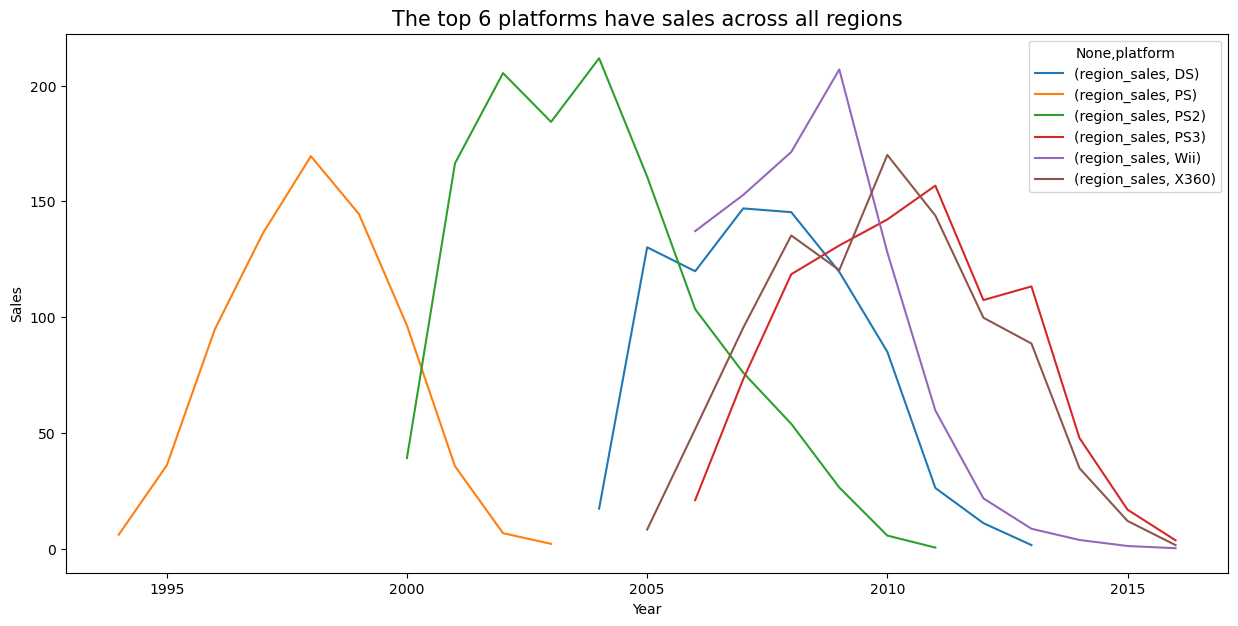

In [24]:
games_top6 = games.query('platform in @platforms').pivot_table(index=['year_of_release'], columns=['platform'], values=['region_sales'], aggfunc='sum')
games_top6.plot(figsize=(15, 7))
plt.title('The top 6 platforms have sales across all regions', fontsize=(15))
plt.xlabel('Year', fontsize=(10))
plt.ylabel('Sales', fontsize=(10))
plt.show()

Let's assume that the period from 2014 will be relevant.

In [25]:
games_2014 = games.query('year_of_release > 2013')


In [26]:
top_platforms_2014 = games_2014['platform'].value_counts() 
top_platforms_2014 = pd.to_numeric(top_platforms_2014, errors='coerce', downcast='float')
platforms_2014 = games_2014['platform'].unique()
platforms_2014

array(['PS4', '3DS', 'XOne', 'WiiU', 'PS3', 'X360', 'PC', 'Wii', 'PSV',
       'PSP'], dtype=object)

PSP sales approached 0 by 2015. Overall, sales of all platforms declined by 2016.
At the beginning of the current period, PS4 was the leader in sales, with sales of about 80 million copies, and XOne, with sales of about 50 million copies. And since 2015, these platforms have dropped quite a bit in sales, by about 10 million copies by 2016.

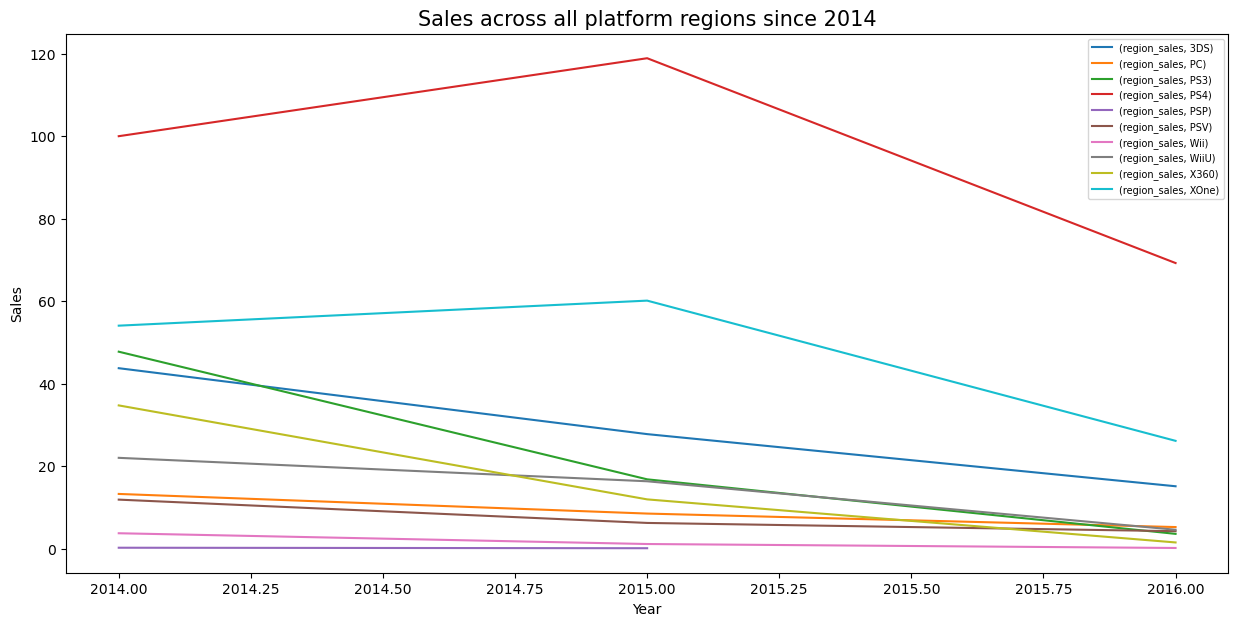

In [27]:
top_games_2014 = games_2014.query('platform in @platforms_2014').pivot_table(index=['year_of_release'], columns=['platform'], values=['region_sales'], aggfunc='sum')
top_games_2014.plot(figsize=(15, 7))
plt.title('Sales across all platform regions since 2014', fontsize=(15))
plt.xlabel('Year', fontsize=(10))
plt.ylabel('Sales', fontsize=(10))
plt.legend(fontsize=(7))

plt.show()

In [28]:
five_platforms_2014 = games_2014.pivot_table(index='platform', values='region_sales', aggfunc='sum')
five_platforms_2014 = five_platforms_2014.sort_values(by='region_sales', ascending=False).head(5)
five_platforms_2014
platforms_2014 = ['PS4', 'XOne', '3DS', 'PS3', 'X360']

In [29]:
top_5_platforms_2014 = games_2014.query('platform in @platforms_2014')
top_5_platforms_2014

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,region_sales
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,-1,NaN,-1,14.63
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97,8.3,M,12.62
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,-1,NaN,-1,11.68
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82,4.3,E,8.58
87,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,-1,NaN,-1,7.98
...,...,...,...,...,...,...,...,...,...,...,...,...
16672,Metal Gear Solid V: The Definitive Experience,XOne,2016,Action,0.01,0.00,0.00,0.00,-1,NaN,M,0.01
16674,Tsukigime Ranko's Longest Day,PS3,2014,Action,0.00,0.01,0.00,0.00,-1,NaN,-1,0.01
16677,Aikatsu Stars! My Special Appeal,3DS,2016,Action,0.00,0.00,0.01,0.00,-1,NaN,-1,0.01
16691,Dynasty Warriors: Eiketsuden,PS3,2016,Action,0.00,0.00,0.01,0.00,-1,NaN,-1,0.01


Text(0, 0.5, 'Sales')

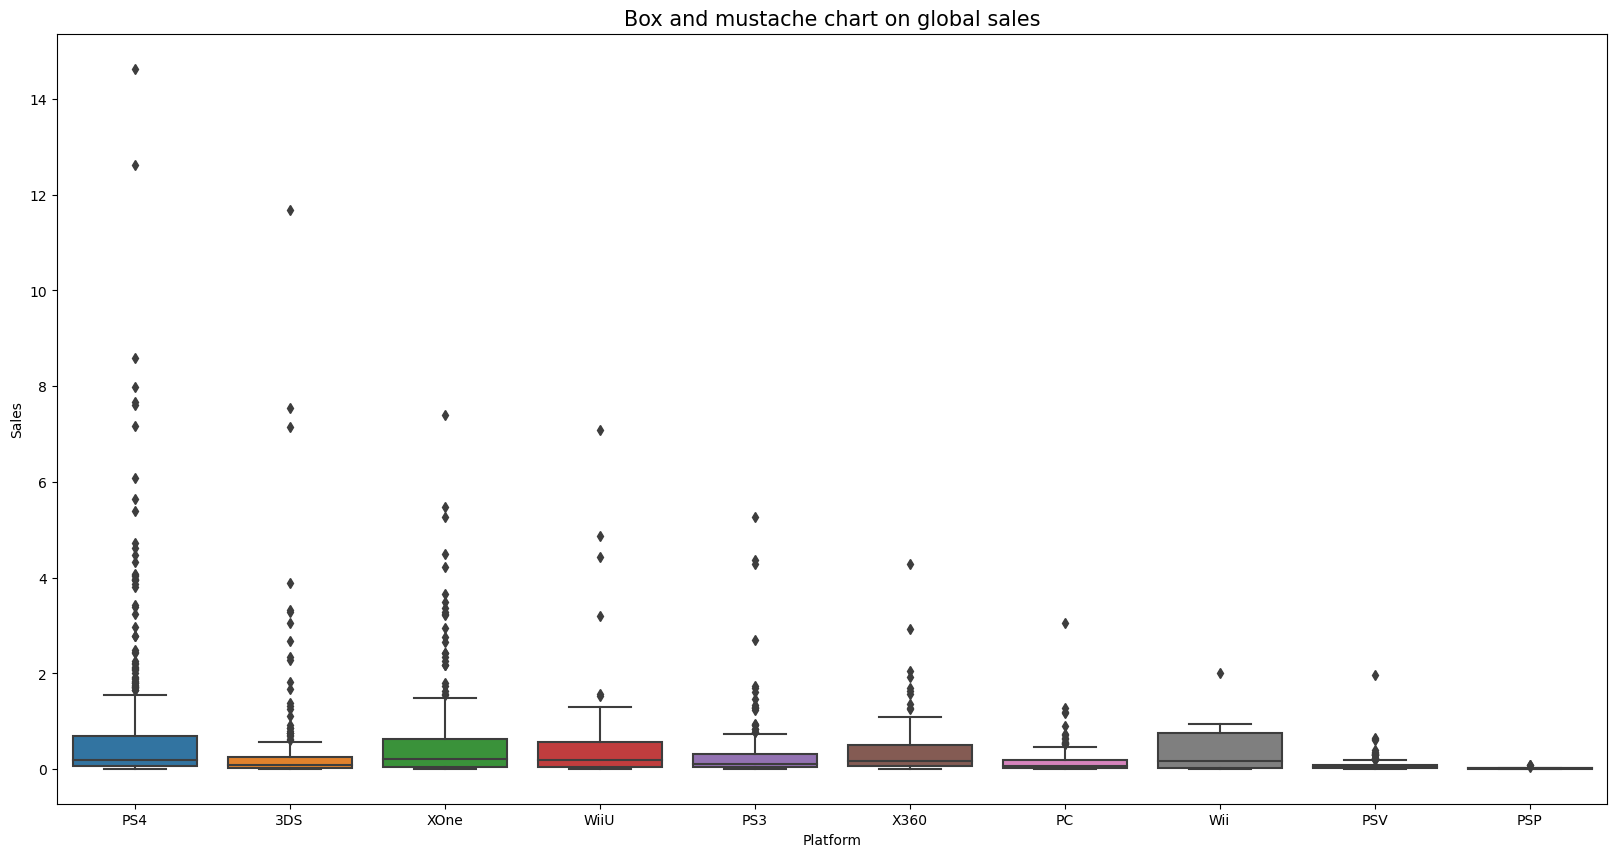

In [30]:
plt.figure(figsize=(20,10))
sns.boxplot(data=games_2014, x='platform', y='region_sales')
plt.title('Box and mustache chart on global sales', fontsize=(15))
plt.xlabel('Platform', fontsize=(10))
plt.ylabel('Sales', fontsize=(10))


(0.0, 0.8)

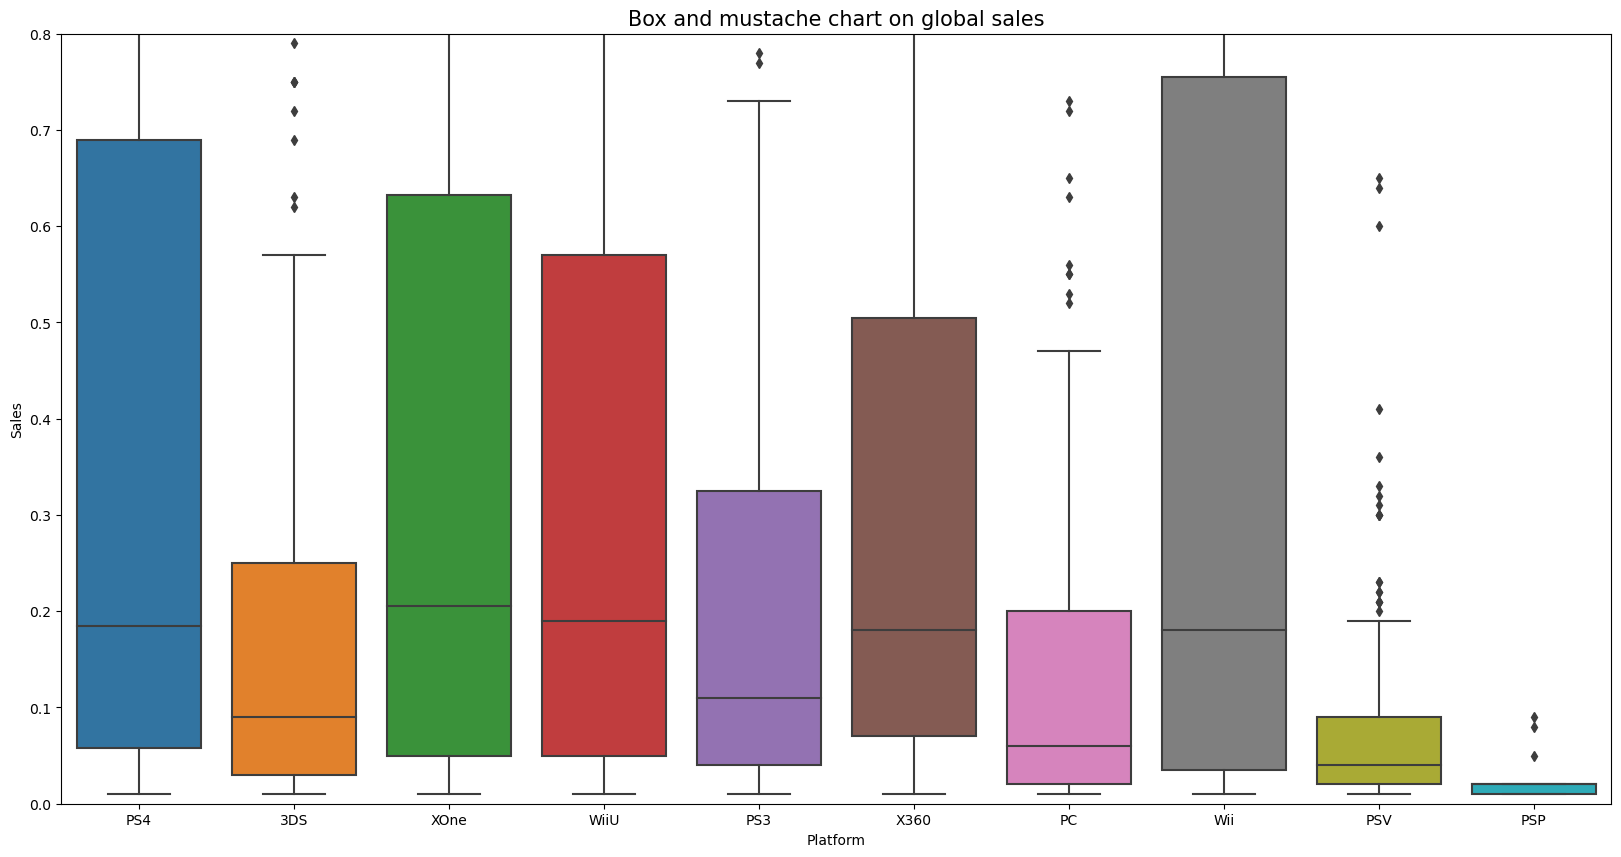

In [31]:
plt.figure(figsize=(20,10))
sns.boxplot(data=games_2014, x='platform', y='region_sales')
plt.title('Box and mustache chart on global sales', fontsize=(15))
plt.xlabel('Platform', fontsize=(10))
plt.ylabel('Sales', fontsize=(10))
plt.ylim([0, 0.8])

The sales data is not symmetrical, and there are also outliers. The median value for the PS4, XOne, WiiU, X360, Wii platforms is approximately 200 thousand copies, for the rest it is approximately at the level of 100 thousand copies. The upper limit of sales is the highest for PS4 and Wii. The PS4 and X360 have the largest gap between the lower quartile and the lower bound. Most of the values are above the median. The distribution is shifted to the right.


It is difficult to talk about the relationship between critics' reviews and sales of games for the PS4 platform, because enough games with scores above 60 have sales approaching zero.

0.4026614122246821

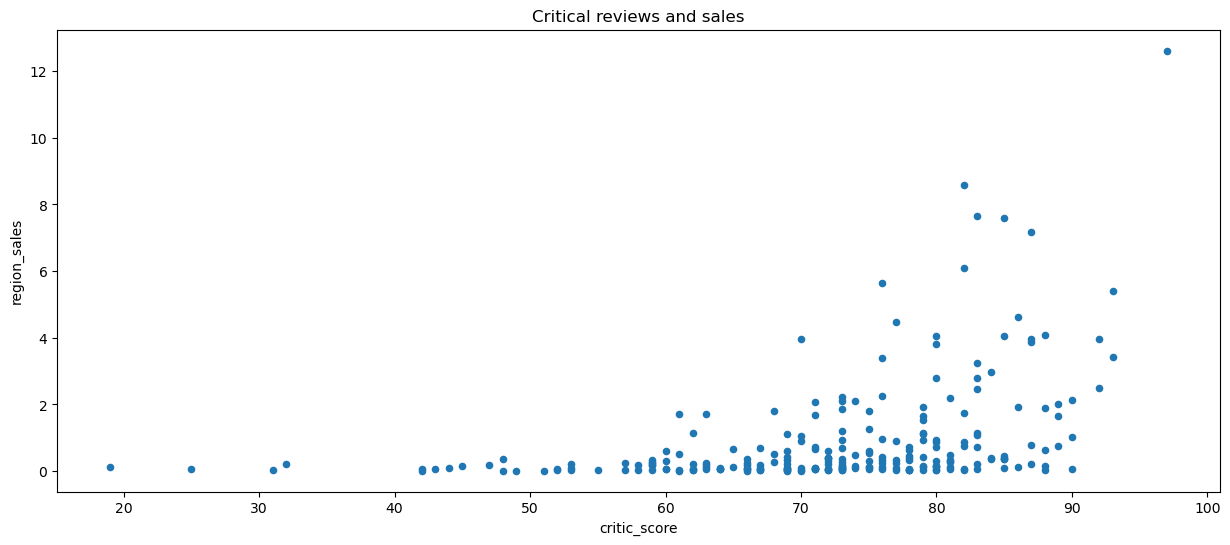

In [32]:
games_2014_ps4 = games_2014.query('platform == "PS4"')
games_2014_fltd = games_2014_ps4.query('critic_score > 0')
games_2014_fltd.plot(figsize=(15,6), kind='scatter', x='critic_score', y='region_sales')
plt.title('Critical reviews and sales')

games_2014_fltd.query('platform == "PS4"')['critic_score'].corr(games_2014_fltd.query('platform == "PS4"')['region_sales'])

-0.04013158815891951

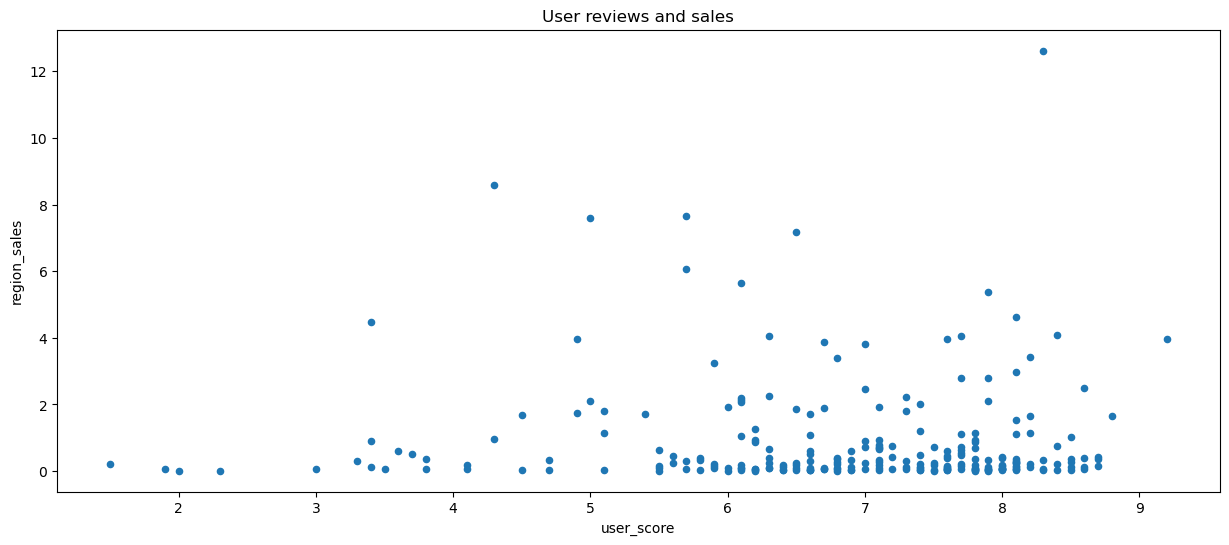

In [33]:
games_2014.query('platform == "PS4"').plot(figsize=(15,6), kind='scatter', x='user_score', y='region_sales')
plt.title('User reviews and sales')

games_2014.query('platform == "PS4"')['user_score'].corr(games_2014.query('platform == "PS4"')['region_sales'])

-0.013070307681861371

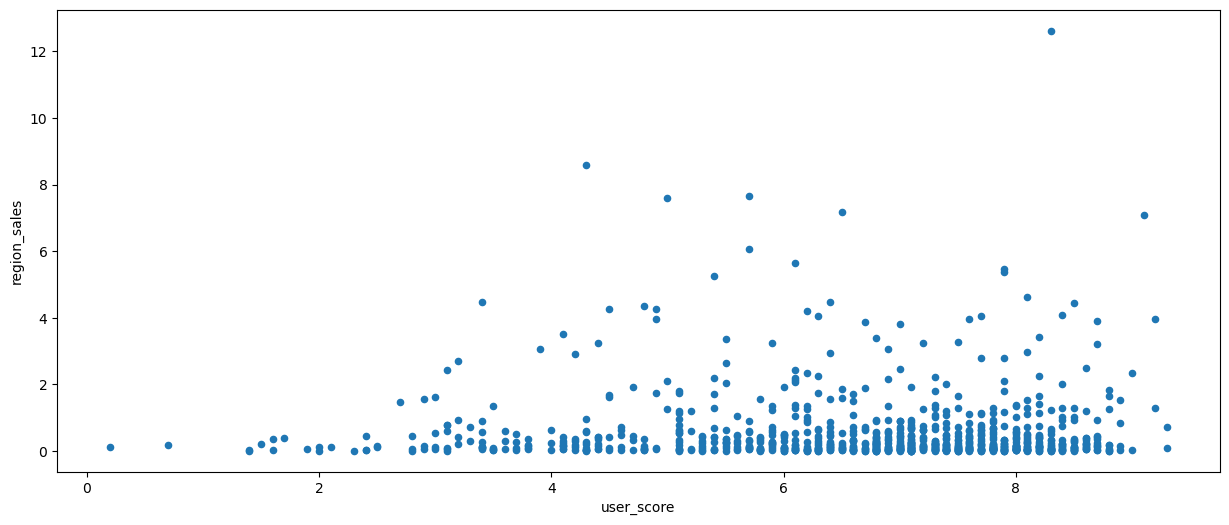

In [34]:
games_2014.plot(figsize=(15,6), kind='scatter', x='user_score', y='region_sales')
games_2014['user_score'].corr(games_2014['region_sales'])

The correlation is extremely weak, and it is negative, that is, the lower the user rating, the higher the sales will be. But according to the schedule, it is still noticeable that with the growth of user ratings, game sales are growing.

<AxesSubplot:xlabel='critic_score', ylabel='region_sales'>

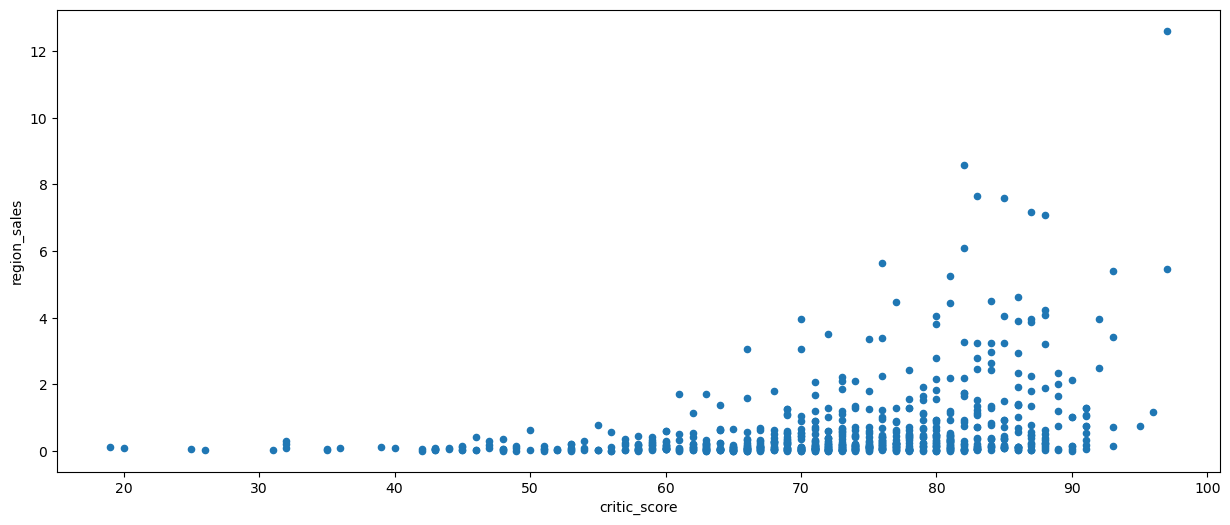

In [35]:
games_2014_all_platforms = games_2014.query('critic_score > 0')
games_2014_all_platforms.query('platform == platform')['critic_score'].corr(games_2014_all_platforms.query('platform == platform')['region_sales'])
games_2014_all_platforms.plot(figsize=(15,6), kind='scatter', x='critic_score', y='region_sales')


If you look at the distribution of sales relative to critics' ratings or user ratings across all platforms, you can see the same conclusion as for the PS4 separately.

,region_sales,critic_score,user_score
region_sales,1.000000,0.428677,-0.091734
critic_score,0.428677,1.000000,0.440977
user_score,-0.091734,0.440977,1.000000


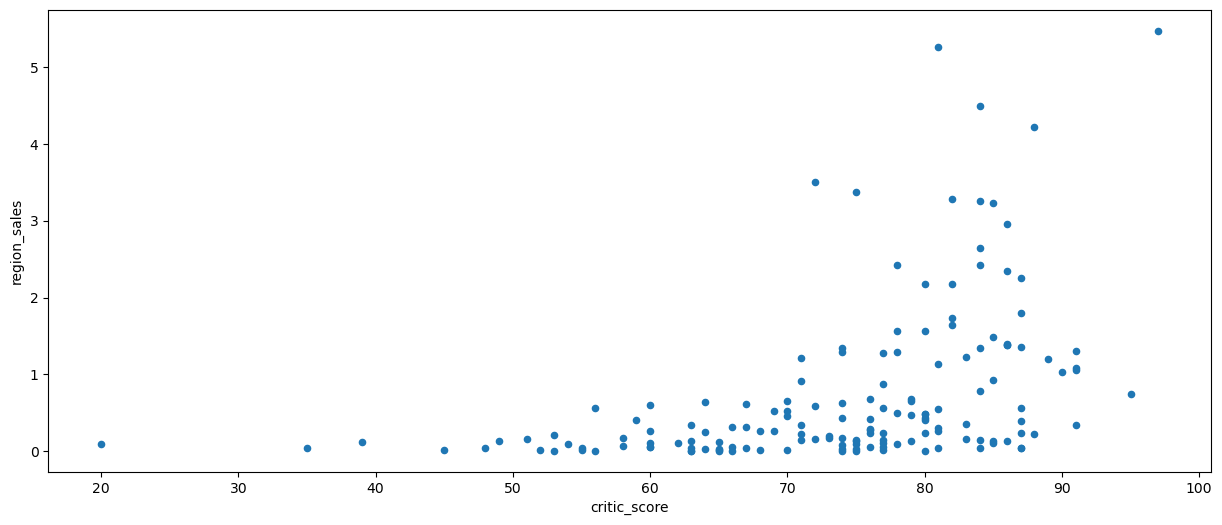

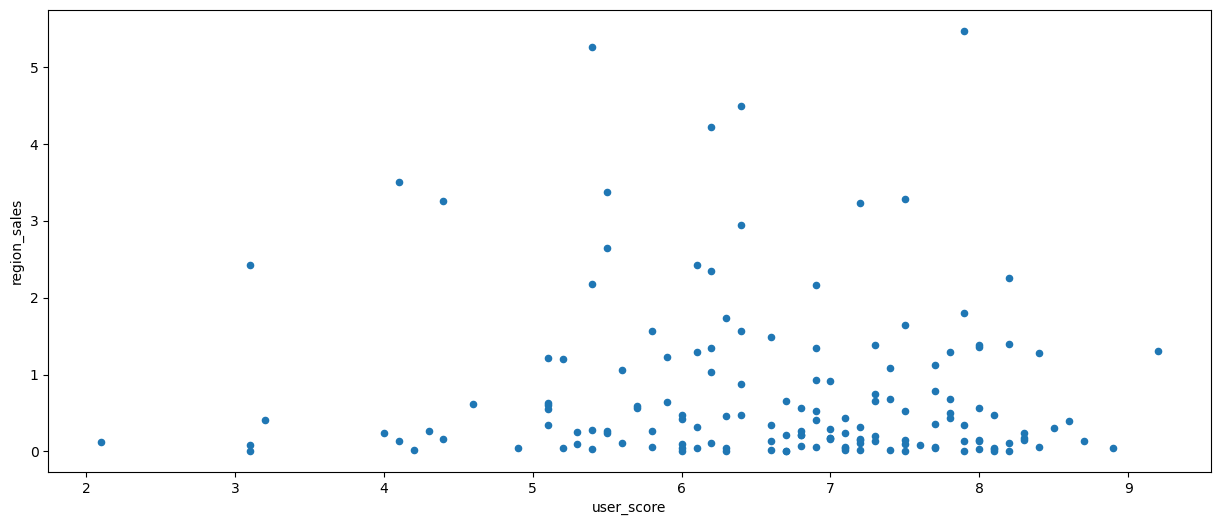

In [36]:
def score(platform):
    temp = games_2014_all_platforms[games_2014_all_platforms['platform'] == platform]
    temp.index = temp.index.astype('int')
    temp[['region_sales', 'critic_score', 'user_score']].corr()
    temp.plot(figsize=(15,6), kind='scatter', x='critic_score', y='region_sales')
    temp.plot(figsize=(15,6), kind='scatter', x='user_score', y='region_sales')
    display(temp[['region_sales', 'critic_score', 'user_score']].corr())

score('XOne')

,region_sales,critic_score,user_score
region_sales,1.000000,0.314117,0.279850
critic_score,0.314117,1.000000,0.862485
user_score,0.279850,0.862485,1.000000


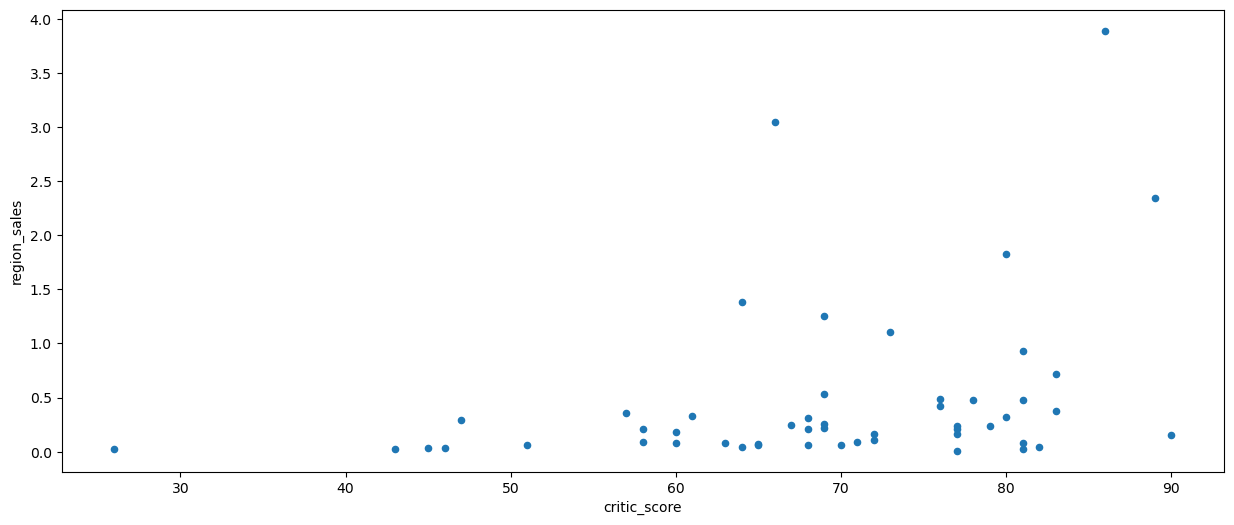

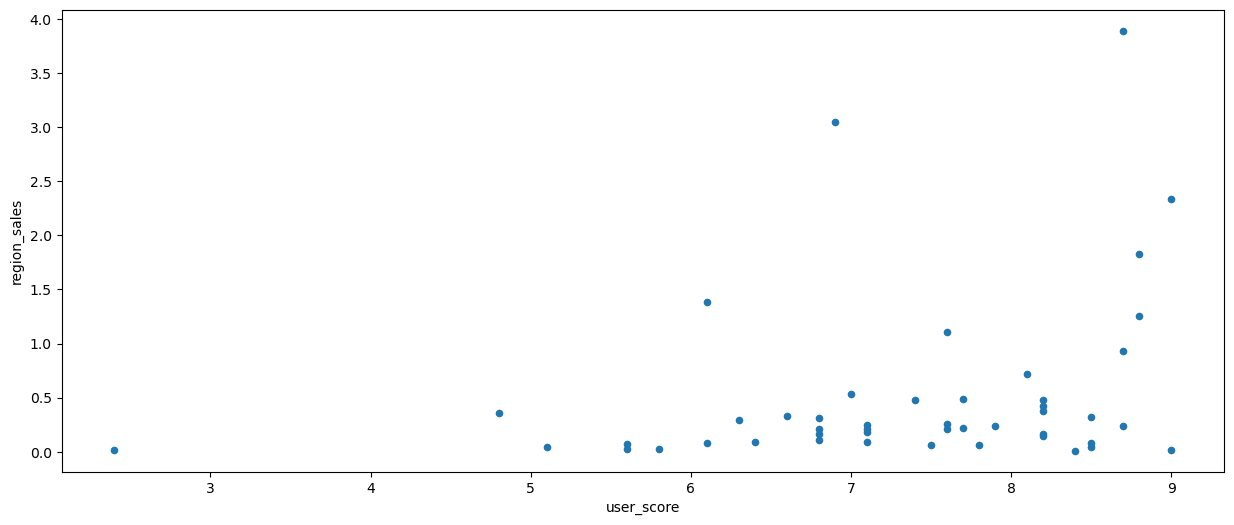

In [37]:
score('3DS')

,region_sales,critic_score,user_score
region_sales,1.000000,0.525723,0.336514
critic_score,0.525723,1.000000,0.625309
user_score,0.336514,0.625309,1.000000


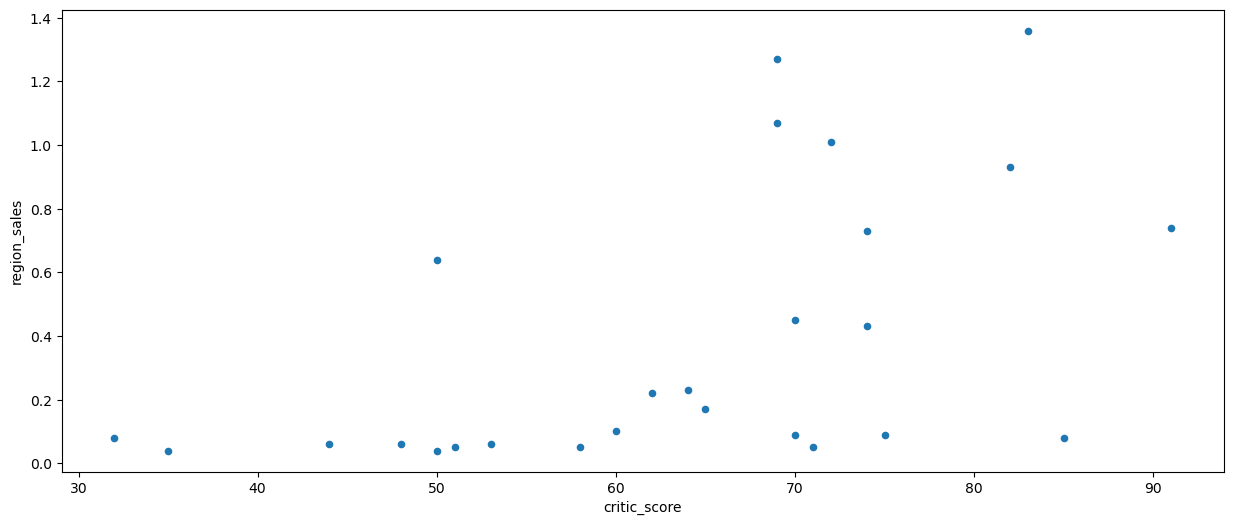

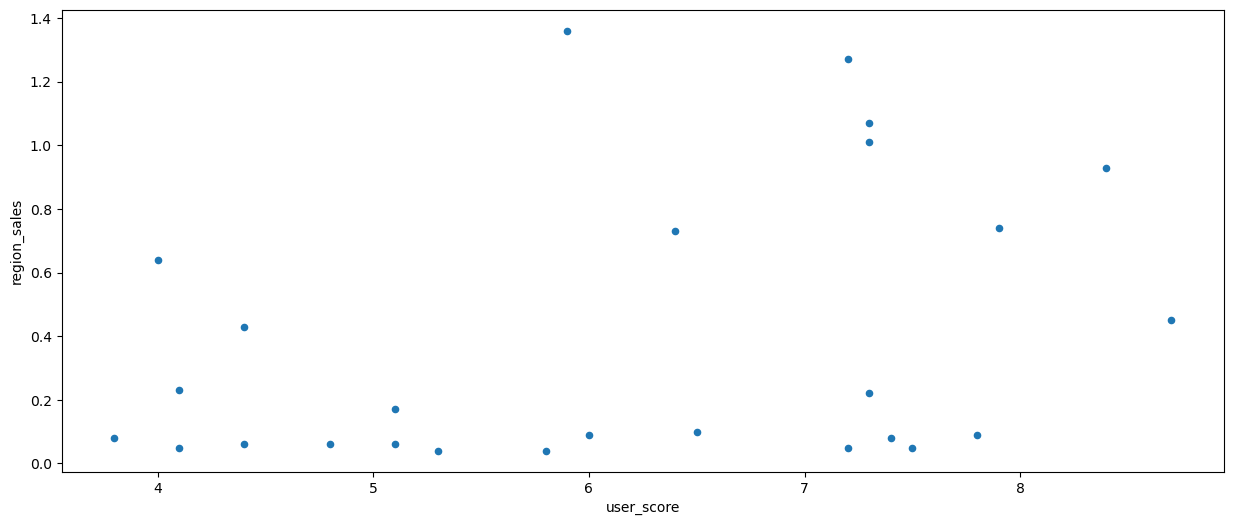

In [38]:
score('X360')

The correlation for other platforms, which had some of the highest sales figures by region, is quite weak. Nevertheless, platforms other than the X360 have the same tendency as the PS4, based on the graphs, we can conclude that sales are still related to estimates, since it is noticeable that with increasing estimates, the number of copies sold also increases.
For the X360 platform, there is no relationship between user and critic ratings and sales.

<AxesSubplot:xlabel='genre'>

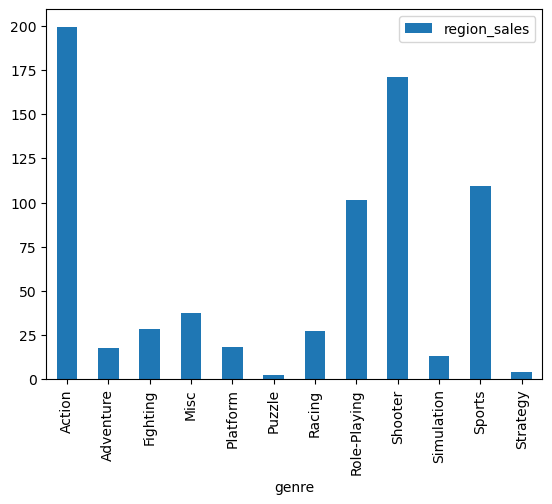

In [39]:
games_2014.pivot_table(index='genre', values='region_sales', aggfunc='sum').plot(kind='bar')

Among the sales, the genres "action" and "shooter" are leading by a large margin, the least sold are "strategy" and "puzzle"

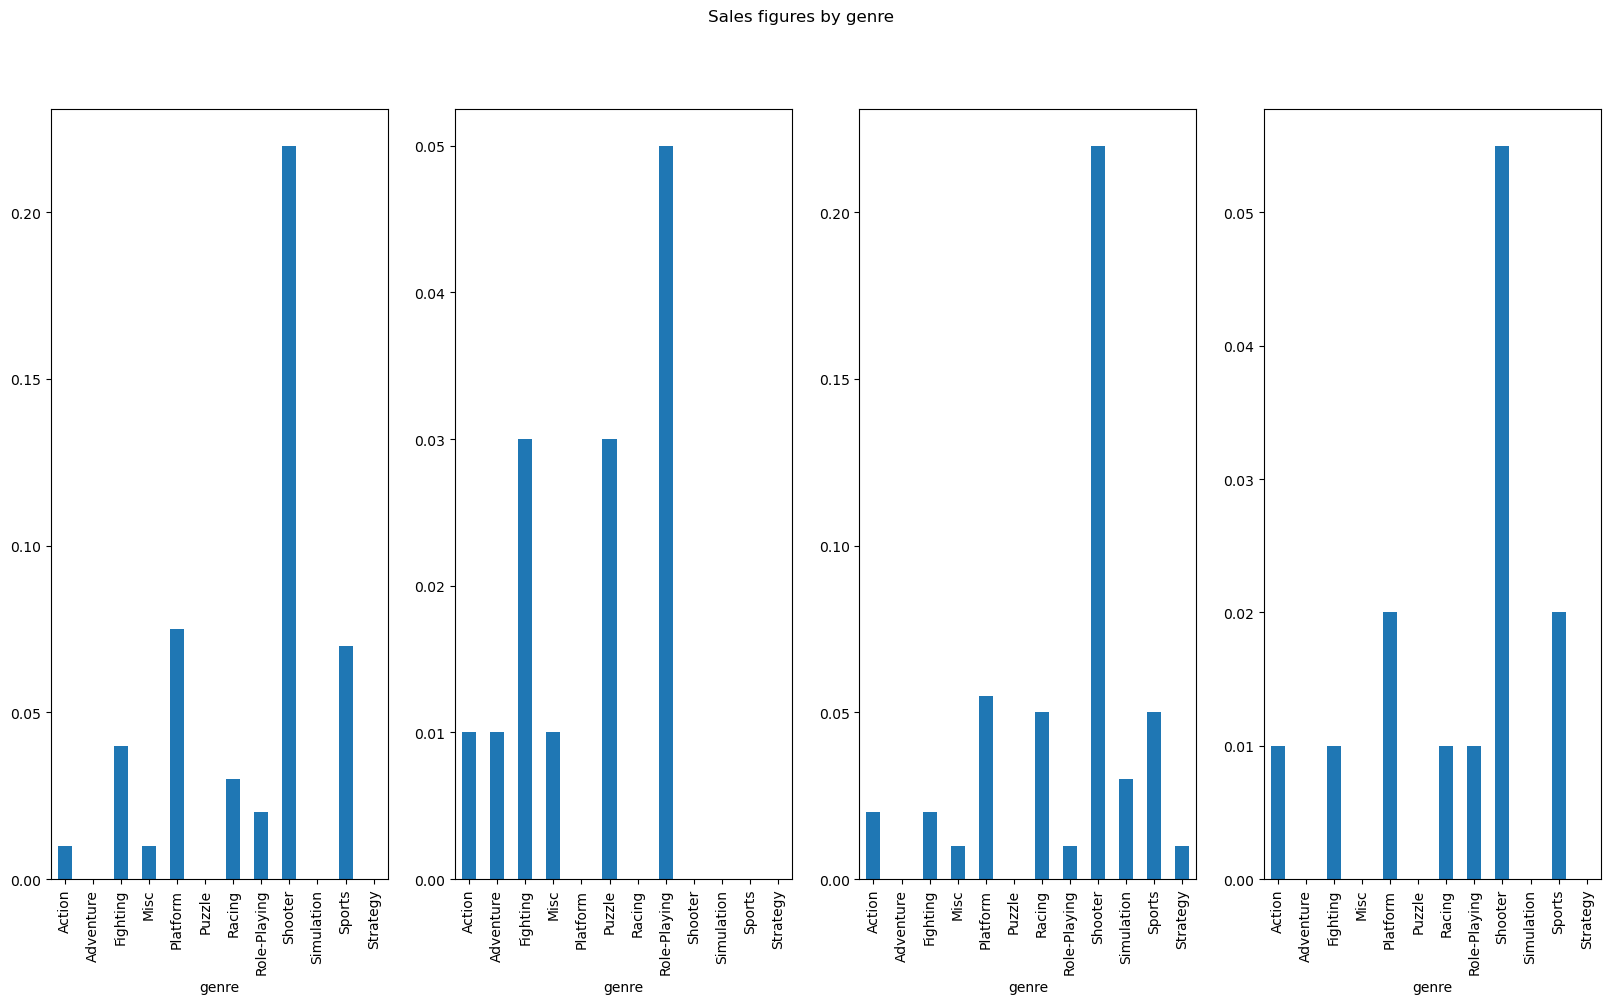

In [40]:
def genre_stat (game_genre, ax): 
    games_2014.groupby('genre')[game_genre].median().plot(ax=ax, kind='bar')
game_genre = ['na_sales', 'jp_sales', 'eu_sales', 'other_sales']
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 10))
fig.suptitle('Sales figures by genre')
for i in range(len(ax)):    
    genre_stat(game_genre[i], ax[i])

If we consider sales by genre separately for each region, then, firstly, it can be noted that there is no data on the sale of some genres in the regions.
In Japan, the most popular genre is "role-playing", in all others "shooter"

## User portraits of each region

In [41]:
na_platforms = games_2014.pivot_table(index='platform', values='na_sales', aggfunc='sum').reset_index()\
.sort_values(by='na_sales', ascending=False)
na_platforms

,platform,na_sales
3,PS4,98.61
9,XOne,81.27
8,X360,28.30
0,3DS,22.64
2,PS3,22.05
7,WiiU,19.36
1,PC,7.23
5,PSV,2.52
6,Wii,2.08
4,PSP,0.00


Text(0.5, 1.0, 'Japan')

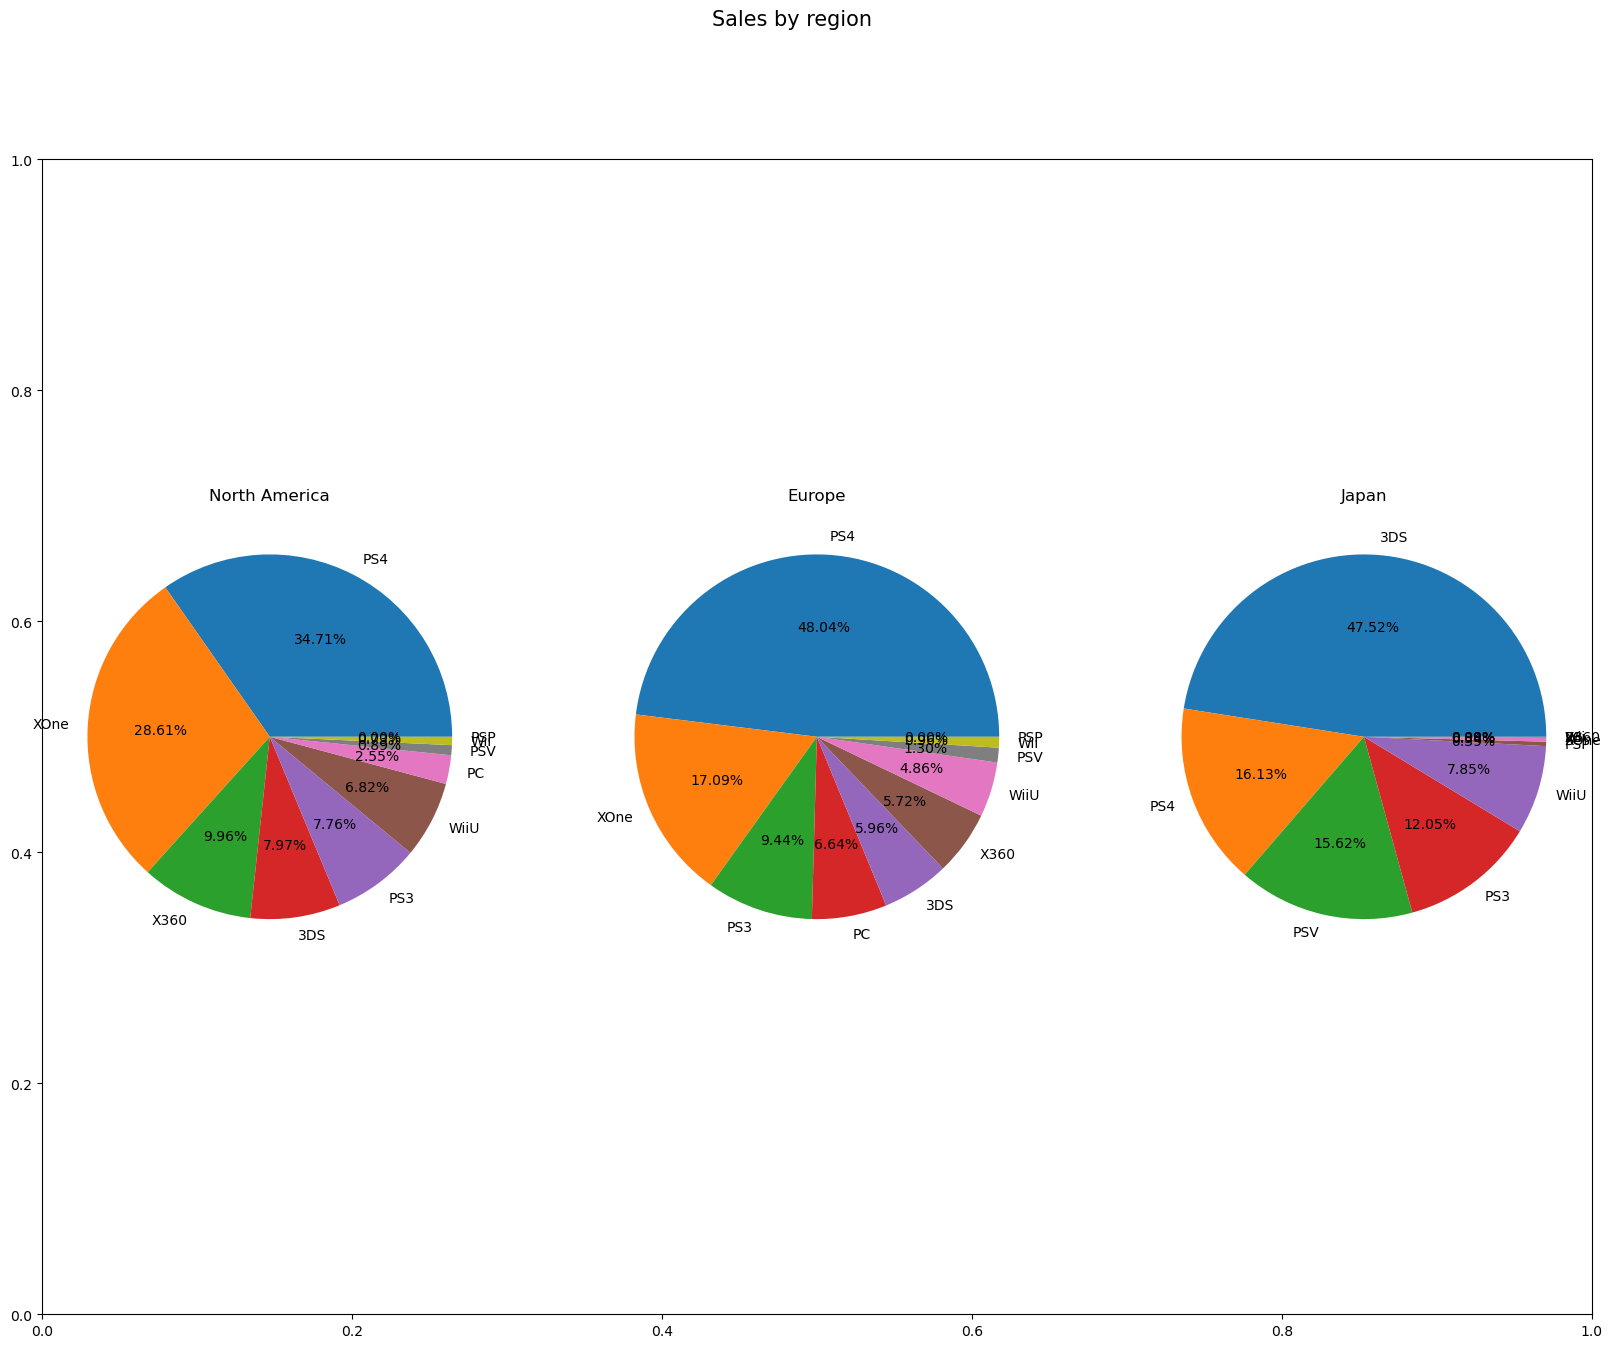

In [42]:
na_platforms = games_2014.pivot_table(index='platform', values='na_sales', aggfunc='sum').reset_index()\
.sort_values(by='na_sales', ascending=False)

eu_platforms = games_2014.pivot_table(index='platform', values='eu_sales', aggfunc='sum').reset_index()\
.sort_values(by='eu_sales', ascending=False)

jp_platforms = games_2014.pivot_table(index='platform', values='jp_sales', aggfunc='sum').reset_index()\
.sort_values(by='jp_sales', ascending=False)
fig, ax = plt.subplots(figsize=(20,15))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.pie(data=na_platforms, x='na_sales', autopct='%.2f%%', labels = na_platforms['platform'])
ax2.pie(data=eu_platforms, x='eu_sales', autopct='%.2f%%', labels = eu_platforms['platform'])
ax3.pie(data=jp_platforms, x='jp_sales', autopct='%.2f%%', labels = jp_platforms['platform'])
plt.suptitle('Sales by region', fontsize=(15))
ax1.set_title('North America')
ax2.set_title('Europe')
ax3.set_title('Japan')

According to the graph, you can see that most of the sales in North America and Europe belong to the PS4, in North America its share is almost 35%, and in Europe 48%. The second place in North America and Europe is occupied by XOne (28.6% and 17%). In Japan, the 3DS platform is leading by a large margin, its sales are approximately 48% of the total, followed by PS4, PSV, PS3, but their number does not reach 20%.

In [43]:
na_genre = games_2014.pivot_table(index='genre', values='na_sales', aggfunc='sum').reset_index()\
.sort_values(by='na_sales', ascending=False)
na_genre 

,genre,na_sales
8,Shooter,79.02
0,Action,72.53
10,Sports,46.13
7,Role-Playing,33.47
3,Misc,15.05
2,Fighting,12.43
6,Racing,8.74
4,Platform,6.79
1,Adventure,5.64
9,Simulation,2.63


In [44]:
eu_genre = games_2014.pivot_table(index='genre', values='eu_sales', aggfunc='sum').reset_index()\
.sort_values(by='eu_sales', ascending=False)
eu_genre

,genre,eu_sales
0,Action,74.68
8,Shooter,65.52
10,Sports,45.73
7,Role-Playing,28.17
6,Racing,14.13
3,Misc,12.86
9,Simulation,7.30
4,Platform,6.80
2,Fighting,6.69
1,Adventure,6.49


In [45]:
jp_genre = games_2014.pivot_table(index='genre', values='jp_sales', aggfunc='sum').reset_index()\
.sort_values(by='jp_sales', ascending=False)
jp_genre 

,genre,jp_sales
7,Role-Playing,31.16
0,Action,29.58
2,Fighting,6.37
3,Misc,5.61
8,Shooter,4.87
1,Adventure,3.60
10,Sports,3.26
4,Platform,2.69
9,Simulation,2.31
6,Racing,1.76


Text(0.5, 1.0, 'Japan')

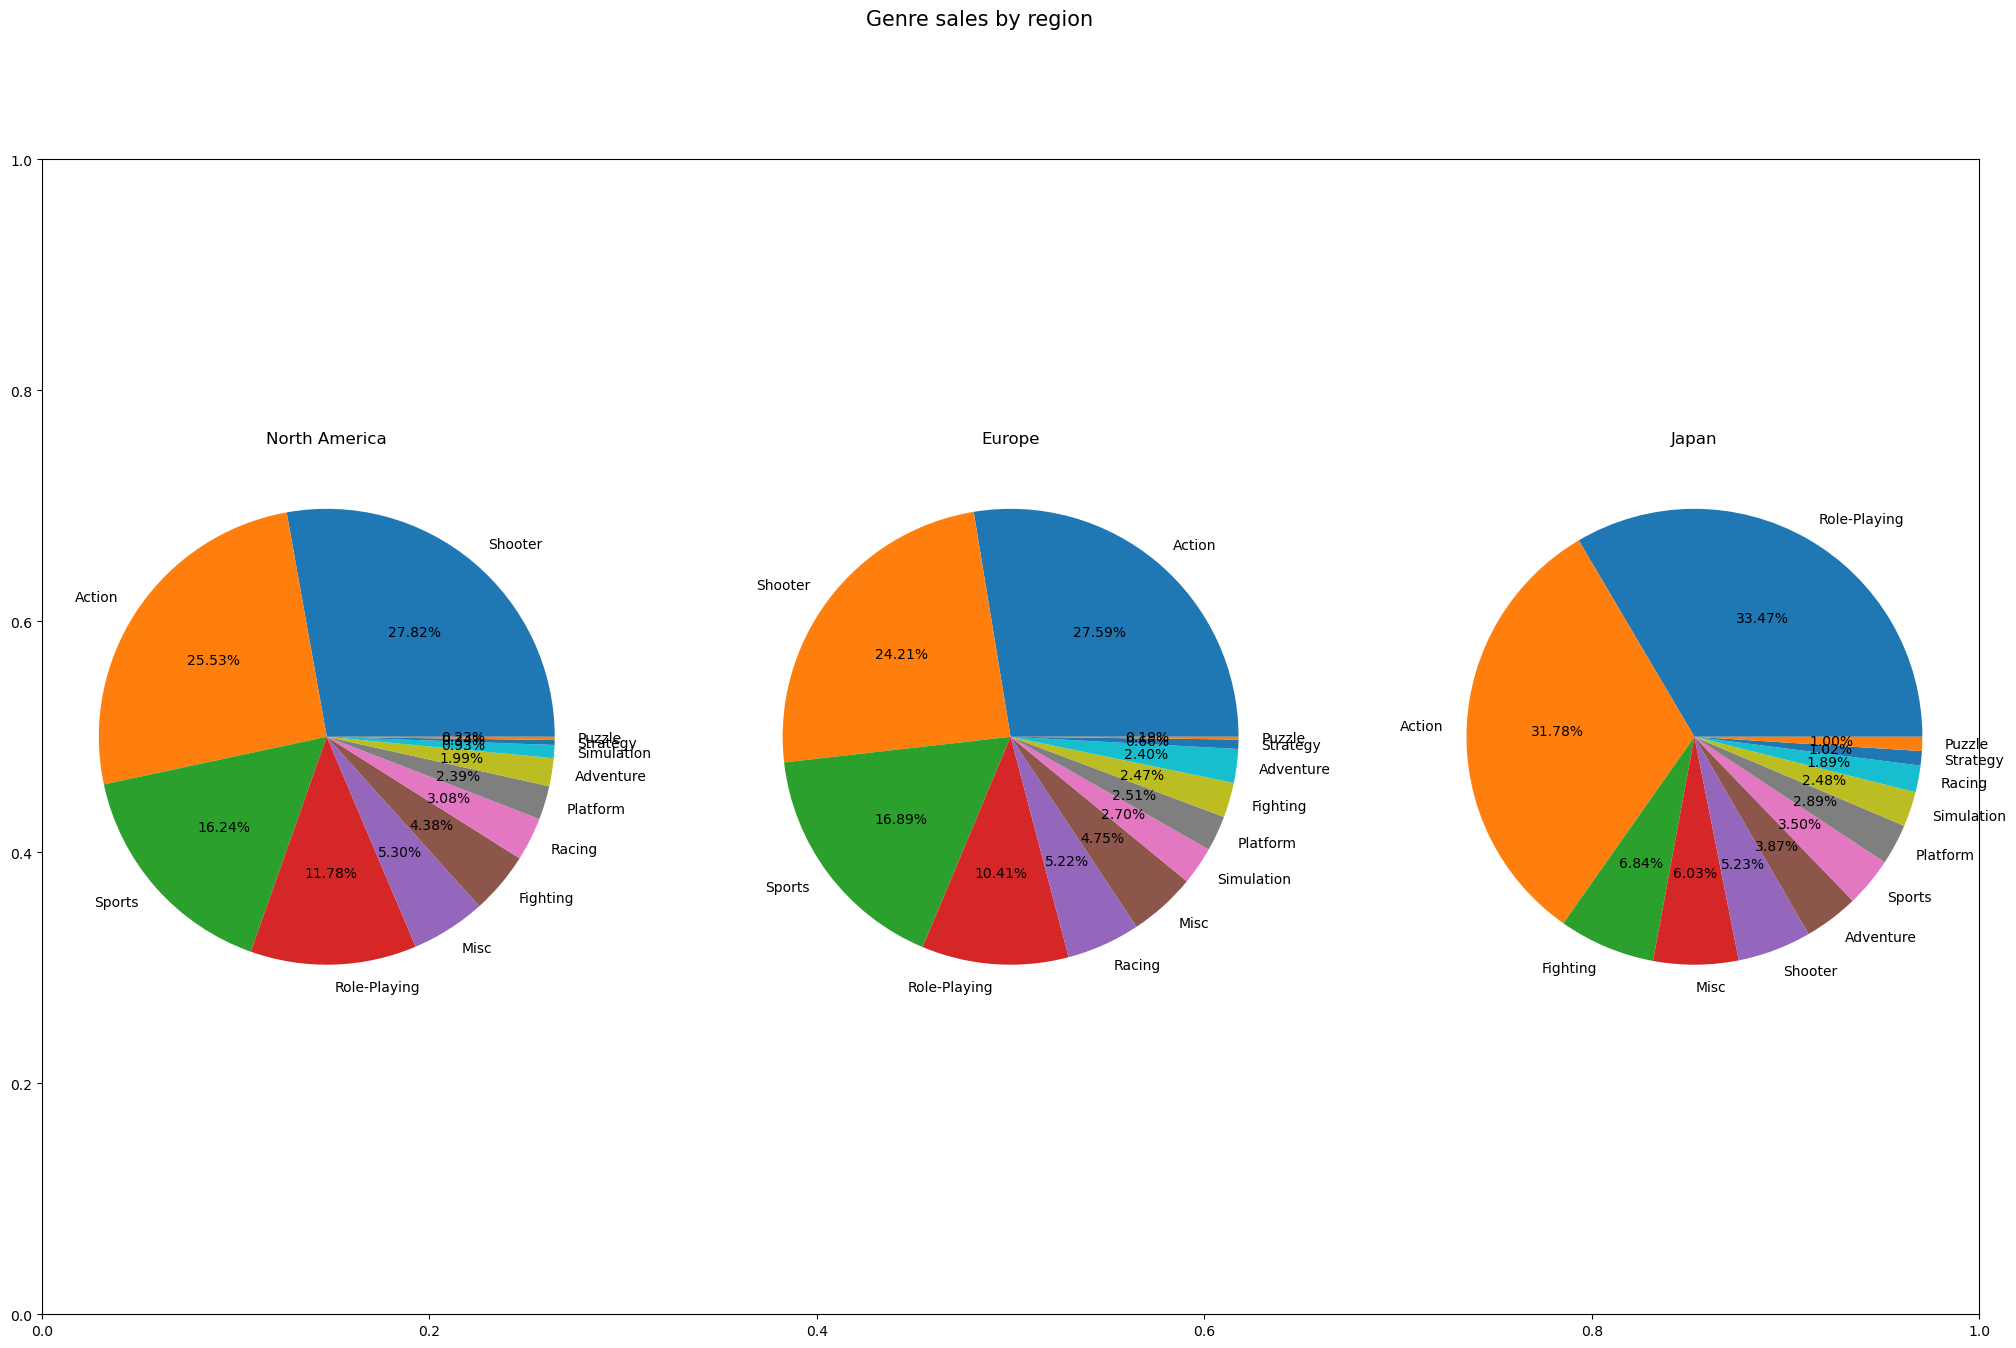

In [46]:
na_genre = games_2014.pivot_table(index='genre', values='na_sales', aggfunc='sum').reset_index()\
.sort_values(by='na_sales', ascending=False)
eu_genre = games_2014.pivot_table(index='genre', values='eu_sales', aggfunc='sum').reset_index()\
.sort_values(by='eu_sales', ascending=False)
jp_genre = games_2014.pivot_table(index='genre', values='jp_sales', aggfunc='sum').reset_index()\
.sort_values(by='jp_sales', ascending=False)


fig, ax = plt.subplots(figsize=(25,15))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.pie(data=na_genre, x='na_sales', autopct='%.2f%%', labels = na_genre['genre'])
ax2.pie(data=eu_genre, x='eu_sales', autopct='%.2f%%', labels = eu_genre['genre'])
ax3.pie(data=jp_genre, x='jp_sales', autopct='%.2f%%', labels = jp_genre['genre'])
plt.suptitle('Genre sales by region', fontsize=(15))
ax1.set_title('North America')
ax2.set_title('Europe')
ax3.set_title('Japan')

In the USA and Europe, the most popular genres are Shooter and Action (in total about 50% of the total), followed by the Sports and Role-Playing genres, sales by genre are distributed approximately equally. And in Japan, Role-Playing is the most popular genre, followed by Action, in total they occupy more than 60% of sales.

In [47]:
games_2014 = games_2014.fillna(-1)
games_2014['rating'].unique()

array([-1, 'M', 'E', 'T', 'E10+'], dtype=object)

In [48]:
games_2014.pivot_table(index='rating', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum')

,eu_sales,jp_sales,na_sales
rating,,,
-1,58.95,56.90,64.72
E,58.06,8.94,50.74
E10+,26.16,4.46,33.23
M,93.44,8.01,96.42
T,34.07,14.78,38.95


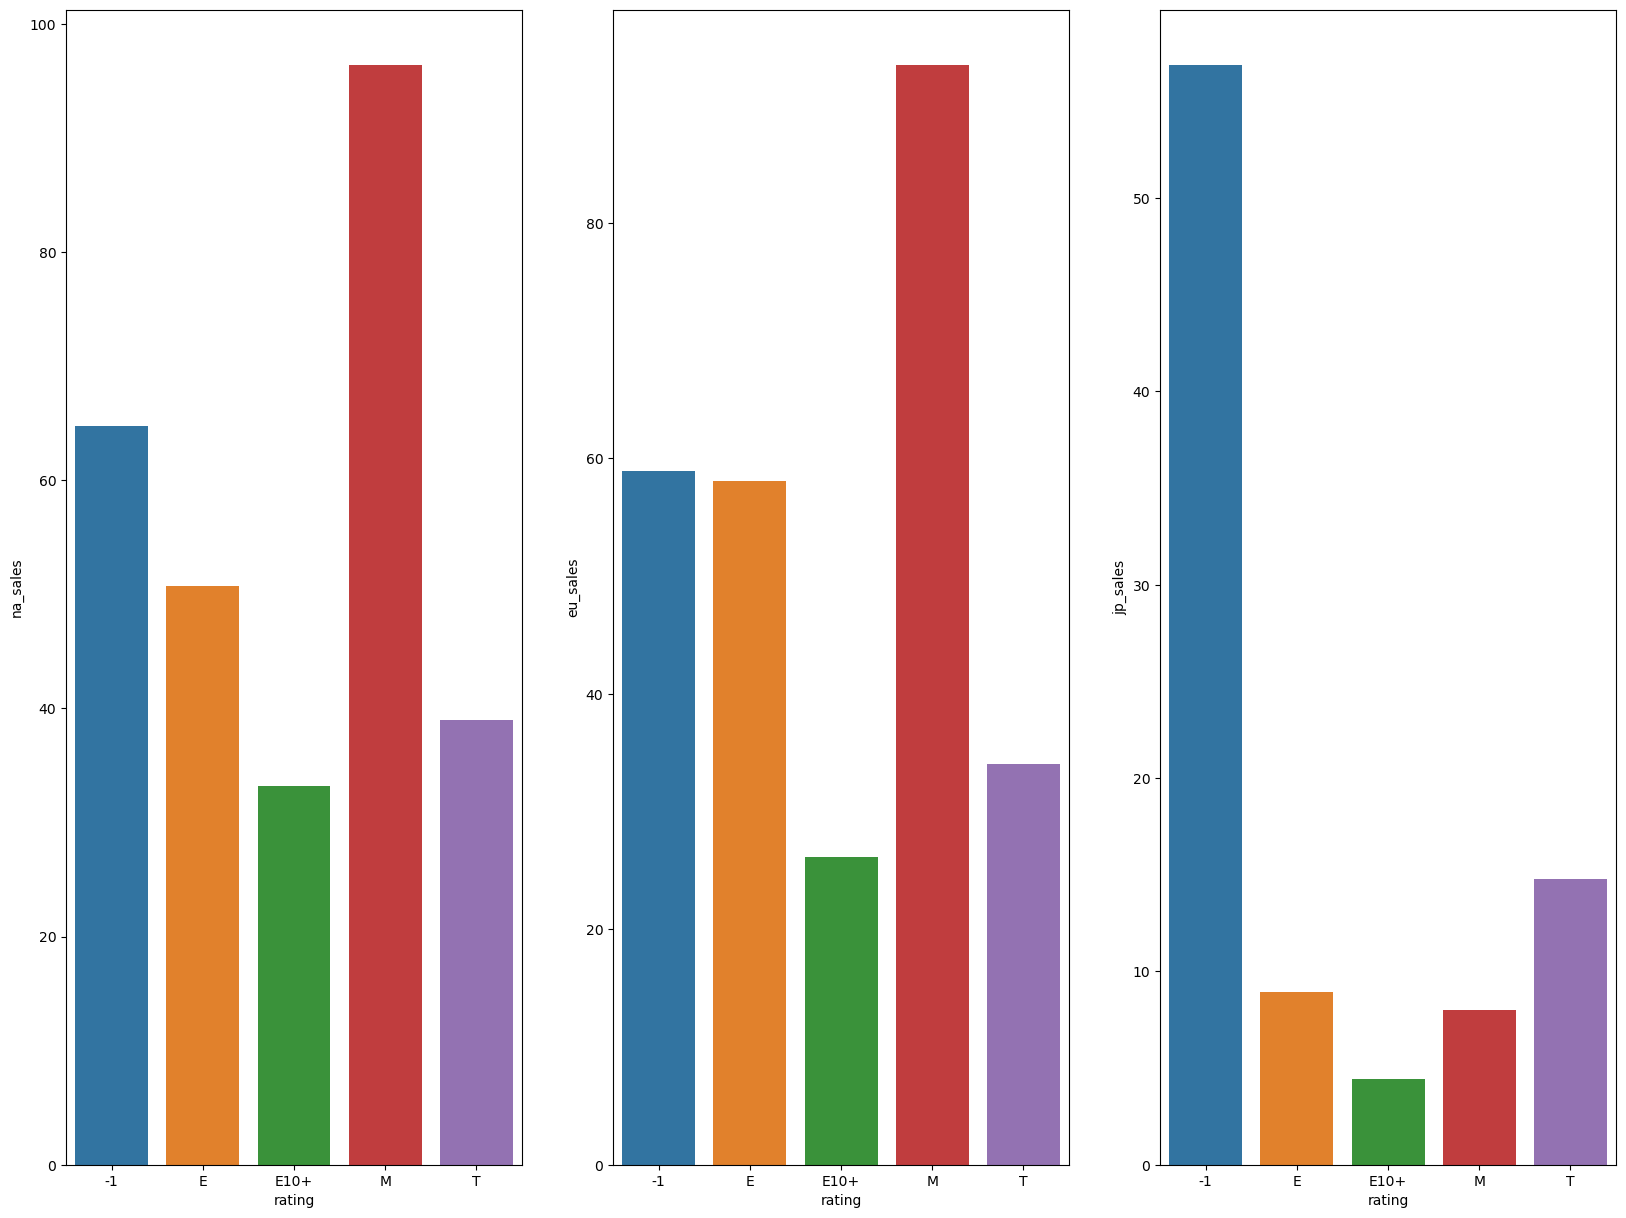

In [49]:
games_raiting = games_2014.pivot_table(index='rating', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum')
fig, axes = plt.subplots(1,3, figsize=(20,15))
sns.barplot(x=games_raiting.index, y=games_raiting['na_sales'], ax=axes[0])
sns.barplot(x=games_raiting.index, y=games_raiting['eu_sales'], ax=axes[1])
sns.barplot(x=games_raiting.index, y=games_raiting['jp_sales'], ax=axes[2])
plt.show()

Despite the fact that the ESRB rating is used primarily in the USA and Canada, data on this rating is also available for other regions, that is, for Europe and Japan, there is very little data on Japan, which means that the sale of games with such a rating there is something exceptional, this is proved by the graph We used the -1 stub for games that lack ESRB rating data, most of these games are in Japan, but Europe is not much behind North America in terms of sales of ESRB-rated games.

When omissions in the rating column are excluded from the analysis, in principle, the result has not changed much.

So, in North America, sales are leading by a large margin in M-rated games, followed by E-rated games, and the situation is similar in Europe. But in Japan, games with a T rating are in the lead, with an E rating in second place.

## Hypothesis testing

**The first hypothesis**

H0: The average user ratings of the Xbox One and PC platforms are the same;

H1: The average user ratings of the Xbox One and PC platforms differ

**The second hypothesis**

H0: Average user ratings of the genres Action (English "action", action games) and Sports (English "sports competitions") similar;

H1: Average user ratings of the genres Action (English "action", action games) and Sports (English "sports competitions") vary

In [50]:
#first hypothesis
xone_user_score = games_2014[games_2014['platform'] == 'XOne']['user_score'].dropna()
pc_user_score = games_2014[games_2014['platform'] == 'PC']['user_score'].dropna()

alpha = .05

results = st.ttest_ind(
    xone_user_score,
    pc_user_score,
    equal_var=False)
print('P-value', results.pvalue)
if results.pvalue < alpha:
    print('Rejecting the null hypothesis')
else: print('It was not possible to reject the null hypothesis')

P-value 0.26246009492976585
It was not possible to reject the null hypothesis


In [51]:
#Second hypothesis
action_user_score = games_2014[games_2014['genre'] == 'Action']['user_score'].dropna()
sports_user_score = games_2014[games_2014['genre'] == 'Sports']['user_score'].dropna()

alpha = .05

results_1 = st.ttest_ind(
    action_user_score,
    sports_user_score,
    equal_var=False)
print('P-value', results_1.pvalue)
if results_1.pvalue < alpha:
    print('Rejecting the null hypothesis')
else: print('It was not possible to reject the null hypothesis')

P-value 4.829372599882802e-05
Rejecting the null hypothesis


To test the hypothesis, a method was used on the equality of the average of two general populations according to the samples taken from them.
The critical level of statistical significance was compared with the resulting p-value

In [52]:
results_platforms = games_2014.dropna(subset=['user_score']).pivot_table(index='platform', values='user_score', aggfunc='mean')
results_platforms

,user_score
platform,
3DS,1.111321
PC,4.896689
PS3,2.138813
PS4,4.038298
PSP,-1.000000
PSV,1.142034
Wii,0.336364
WiiU,4.317808
X360,4.063063


In [53]:
results_genre = games_2014.dropna(subset=['user_score']).pivot_table(index='genre', values='user_score', aggfunc='mean')
results_genre

,user_score
genre,
Action,2.723586
Adventure,1.151892
Fighting,3.923333
Misc,1.891150
Platform,4.907895
Puzzle,1.564286
Racing,4.415942
Role-Playing,2.966516
Shooter,5.369531


# Conclusion

During the study, it was revealed that sales of some platforms fell significantly over time, and by the end of the study period, sales of all platforms fell markedly. So, at the beginning of the current period, that is, since 2014, PS4 was in the lead and sales were about 80 million copies, and by 2016 they had fallen by about 10 million copies. It was also noticed that PSP sales are extremely low, which indicates a decline in the popularity of this platform.

The median value for the PS4, XOne, WiiU, X360, Wii platforms is approximately 200 thousand copies, for the rest it is approximately at the level of 100 thousand copies. The upper limit of sales is the highest for PS4 and Wii.

A weak correlation was found between the ratings of critics and users and the number of sales. Of course, the higher the score, the higher the sales, but at the same time, a sufficient number of highly rated games have sales approaching 0.

The majority of sales in North America and Europe belong to PS4, in North America its share is almost 35%, and in Europe 48%. The second place in North America and Europe is occupied by XOne (28.6% and 17%). In Japan, the 3DS platform is leading by a large margin, its sales are approximately 48% of the total, followed by PS4, PSV, PS3, but their number does not reach 20%.

In the USA and Europe, the most popular genres are Shooter and Action (in total about 50% of the total), followed by the Sports and Role-Playing genres, sales by genre are distributed approximately equally. And in Japan, Role-Playing is the most popular genre, followed by Action, in total they occupy more than 60% of sales.

In North America, sales are leading in M and E-rated games, while in Europe the situation is similar. But even for North America, a fairly large number of games do not have ESRB rating data. For Japan, most of the games do not have ESRB rating data, due to the fact that this rating is used in the USA and Canada, but of those games for which data is available, games with a T rating are in the lead, in second place with an E rating.

Hypotheses have been investigated: "The average user ratings of the Xbox One and PC platforms are the same" and "Average user ratings of the genres Action (English "action", action games) and Sports (English "sports competitions") different"

The first hypothesis could not be rejected at the significance level of 0.05, since the p-value for the studied data was greater than the critical value, that is, the average user ratings of Xbox One and PC are still the same. If you look at the summary tables, it cannot be said that the average user ratings are identical for Xbox One and PC, nevertheless they are located quite close to each other. And the second hypothesis, on the contrary, was rejected at the significance level of 0.05, the average user ratings for the Action and Sports genres are different, which is proved by the summary table.